In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
from Function.ReceptiveField import *
from Function.SNNModule_v2 import *
from Function.plot_SNN import *
from Function.SNN_230410_total import *
from Function.Stimulation_GPU import *
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Enable GPU support if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

deivce = 'cpu'


GPU available: True
CUDA version: 10.1
Using device: cuda


In [3]:
# Set sensor dimensions (height and width in millimeters)
sensor_h, sensor_w = 19, 16

# Set pixel dimensions (number of pixels in height and width)
pixel_h, pixel_w = 64, 48

# Set image frames per second (FPS)
img_FPS = 60


In [4]:
# Generate Slowly Adapting (SA) and Rapidly Adapting (RA) receptive fields
SA_RF, [SA_step_height, SA_step_width] = generate_mechanoreceptor_to_afferent_rf(
    kernel_w=11, kernel_h=10, step_size=6,device=device)
RA_RF, [RA_step_height, RA_step_width] = generate_mechanoreceptor_to_afferent_rf(
    kernel_w=15, kernel_h=14,step_size=6,device=device)

# Print the shape of the SA_rf variable
print("SA_rf shape:", SA_RF.shape, 'with height =', SA_step_height, 'with width =',SA_step_width)
print("RA_rf shape:", RA_RF.shape, 'with height =', RA_step_height, 'with width =',RA_step_width)

# Define optimized receptive fields
CN_PN_RF = [
    torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]], device=device) * 10,  # Prewitt vertical
]

CN_IN_RF = [
    torch.tensor([[1, 1, 1], [1, 0, 1], [1, 1, 1]], device=device) * 5,  # Prewitt vertical
]

# Define synaptic delays
CN_SD = [
    torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]], device=device),
]

# Check if the sizes of the inner tensors are different and print the index
for i, (PN,IN) in enumerate(zip(CN_PN_RF, CN_IN_RF)):
    if PN.size() != IN.size():
        raise ValueError(
            f"The inner tensors at index {i} have different sizes: {PN.size()} != {IN.size()}")

SA_CN_PN_RF, SA_CN_PN_RF_len = generate_afferent_to_top_rf(CN_PN_RF, pixel_h=SA_step_height,
                                                      pixel_w=SA_step_width, step_size=1, device=device)
SA_CN_IN_RF, SA_CN_IN_RF_len = generate_afferent_to_top_rf(CN_IN_RF, pixel_h=SA_step_height,
                                                      pixel_w=SA_step_width, step_size=1, device=device)
SA_CN_SD, SA_CN_SD_len = generate_afferent_to_top_rf(CN_SD, pixel_h=SA_step_height,
                                                                      pixel_w=SA_step_width, step_size=1, device=device)


RA_CN_PN_RF, RA_CN_PN_RF_len = generate_afferent_to_top_rf(CN_PN_RF, pixel_h=RA_step_height,
                                                      pixel_w=RA_step_width, step_size=1, device=device)
RA_CN_IN_RF, RA_CN_IN_RF_len = generate_afferent_to_top_rf(CN_IN_RF, pixel_h=RA_step_height,
                                                      pixel_w=RA_step_width, step_size=1, device=device)
RA_CN_SD, RA_CN_SD_len = generate_afferent_to_top_rf(CN_SD, pixel_h=RA_step_height,
                                                                      pixel_w=RA_step_width, step_size=1, device=device)

print(len(SA_RF), len(SA_CN_PN_RF), len(SA_CN_IN_RF))


Complete! Generated 70 receptive fields from mechanoreceptor to afferents with kernel size 10x11.
Complete! Generated 54 receptive fields from mechanoreceptor to afferents with kernel size 14x15.
SA_rf shape: torch.Size([70, 3072]) with height = 7 with width = 10
RA_rf shape: torch.Size([54, 3072]) with height = 6 with width = 9
Complete! Generated 40 receptive fields from afferents to the top with kernel size 3x3. with step size 4x7
Complete! Generated 40 receptive fields from afferents to the top with kernel size 3x3. with step size 4x7
Complete! Generated 40 receptive fields from afferents to the top with kernel size 3x3. with step size 4x7
Complete! Generated 28 receptive fields from afferents to the top with kernel size 3x3. with step size 3x6
Complete! Generated 28 receptive fields from afferents to the top with kernel size 3x3. with step size 3x6
Complete! Generated 28 receptive fields from afferents to the top with kernel size 3x3. with step size 3x6
70 40 40


In [5]:
# Create Izhikevich layers
SA_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(SA_RF), a_decay=1, device=device)
SA_CN_PN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(SA_CN_PN_RF), a_decay=1, device=device)
SA_CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(SA_CN_IN_RF), a_decay=1, device=device)

RA_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(RA_RF), a_decay=1, device=device)
RA_CN_PN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(RA_CN_PN_RF), a_decay=1, device=device)
RA_CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(RA_CN_IN_RF), a_decay=1, device=device)

SA_layers = [SA_layer, SA_CN_PN_layer, SA_CN_IN_layer]
RA_layers = [RA_layer, RA_CN_PN_layer, RA_CN_IN_layer]

SA_synapse = Synapse(SA_RF.to(device), device=device)
SA_CN_PN_synapse = Synapse(SA_CN_PN_RF.to(device),delays = SA_CN_SD, device=device)
SA_CN_IN_synapse = Synapse(SA_CN_IN_RF.to(device),delays = SA_CN_SD, device=device)

RA_synapse = Synapse(RA_RF.to(device), device=device)
RA_CN_PN_synapse = Synapse(RA_CN_PN_RF.to(device),delays = RA_CN_SD, device=device)
RA_CN_IN_synapse = Synapse(RA_CN_IN_RF.to(device),delays = RA_CN_SD, device=device)

SA_synapses = [SA_synapse, SA_CN_PN_synapse, SA_CN_IN_synapse]
RA_synapses = [RA_synapse, RA_CN_PN_synapse, RA_CN_IN_synapse]


# RA_synapses[0].weights

layers initialized
layers initialized
layers initialized
layers initialized
layers initialized
layers initialized
Synapses initialized
Synapses initialized
Synapses initialized
Synapses initialized
Synapses initialized
Synapses initialized


cuda:0


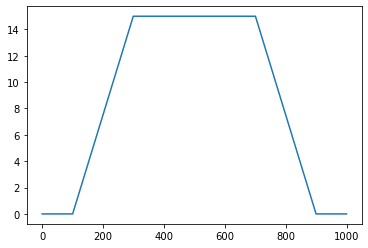

In [6]:
num_stim = 1000
stimulation_vertical = torch.zeros((pixel_h, pixel_w, num_stim), device=device)
max_F = 15
F_array = np.concatenate([
    np.zeros((100,)),
    np.linspace(0, max_F, 200),
    np.full((400,), max_F),
    np.linspace(max_F, 0, 200),
    np.zeros((100,))
])
for i, F_i in enumerate(F_array):
    stim_dot = elongated_stim(F=F_i*2, pixel_h=pixel_h,
                              pixel_w=pixel_w, orientation='horizontal')
    # Use 'vertical' for vertically elongated stimulus
    # stim_dot = elongated_stim(F=F_i, pixel_h=pixel_h, pixel_w=pixel_w, orientation='vertical')
    stimulation_vertical[:, :, i] = stim_dot
    # if i % 200 == 0:
    #     plt.imshow(stimulation_vertical[:, :, i].cpu(),
    #                cmap='jet', vmin=0, vmax=max_F)

    #     plt.show()
print(stimulation_vertical.device)

plt.plot(F_array)
plt.show()


In [7]:
S = SNNModel([SA_layers,RA_layers],[SA_synapses,RA_synapses],device)

S.feedforward(stimulation_vertical)

plot_spike_times(S.SA_spike_times[0])
plot_spike_times(S.SA_spike_times[2])
plot_spike_times(S.RA_spike_times[0])
plot_spike_times(S.RA_spike_times[2])



start feedforward


RuntimeError: Size does not match at dimension 0 expected index [70, 40] to be smaller than src [40, 50] apart from dimension 1

In [ ]:
S.SA_synapses[2].weights


tensor([[5., 5., 5.,  ..., 0., 0., 0.],
        [0., 5., 5.,  ..., 0., 0., 0.],
        [0., 0., 5.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 5., 0.],
        [0., 0., 0.,  ..., 5., 5., 5.]], device='cuda:0')